In [ ]:
!pip install tensorflow
!pip install scikit-image
!pip install tensorflow.keras

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install --upgrade scikit-image

In [ ]:
import tensorflow as tf
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available: 0


In [ ]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [ ]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, DepthwiseConv2D, BatchNormalization,ReLU, GlobalAveragePooling2D, Dense, Dropout, Concatenate
from tensorflow.keras.optimizers import Adam
from skimage.feature import graycomatrix, graycoprops

from google.colab import drive

In [ ]:
# Define categories and image size
CATEGORIES = ['GEN_holes','GEN_ladder','GEN_no_defect','GEN_snag','GEN_stain',
              'GEN_thread_defect','GEN_single_fold','GEN_thick_bar','GEN_thin_bar','GEN_slub']
IMG_SIZE = 224
path = "/content/drive/MyDrive/TILDA"
distances = [5, 50]
angles = [0, np.pi/4]

In [ ]:
# Function to extract GLCM features
def extract_glcm_features(gray_img):
    # Change greycomatrix to graycomatrix
    glcm = graycomatrix(gray_img, distances=distances, angles=angles,
                        levels=256, symmetric=True, normed=True)
    features = []
    props = ['contrast', 'dissimilarity', 'homogeneity', 'ASM', 'energy', 'correlation']
    for prop in props:
        feat = graycoprops(glcm, prop)
        features.extend(feat.flatten())
    return features

In [ ]:
# Load images and extract features
X_img, X_glcm, y = [], [], []
for category in CATEGORIES:
    class_num = CATEGORIES.index(category)
    folder_path = os.path.join(path, category)
    for img_name in os.listdir(folder_path):
        img_path = os.path.join(folder_path, img_name)
        gray_img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if gray_img is None or gray_img.shape != (IMG_SIZE, IMG_SIZE):
            continue
        norm_img = gray_img / 255.0
        glcm_features = extract_glcm_features(gray_img)
        X_img.append(norm_img)
        X_glcm.append(glcm_features)
        y.append(class_num)

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/TILDA/GEN_holes'

In [ ]:
# Convert to numpy arrays and preprocess
X_img = np.array(X_img).reshape(-1, IMG_SIZE, IMG_SIZE, 1).astype('float32')
X_glcm = np.array(X_glcm).astype('float32')
y = to_categorical(np.array(y), num_classes=len(CATEGORIES))

# Normalize GLCM features
scaler = StandardScaler()
X_glcm = scaler.fit_transform(X_glcm)

# Split dataset
X_img_train, X_img_test, X_glcm_train, X_glcm_test, y_train, y_test = train_test_split(
    X_img, X_glcm, y, test_size=0.2, random_state=42
)

In [ ]:
import joblib

# Save to your Google Drive
scaler_path = "/content/drive/MyDrive/TILDA/scaler.joblib"
joblib.dump(scaler, scaler_path)
print("✅ Scaler saved to:", scaler_path)

In [ ]:
# Define depthwise separable convolution block
def depthwise_separable_conv_block(x, pointwise_filters, strides):
    x = DepthwiseConv2D(kernel_size=3, strides=strides, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Conv2D(pointwise_filters, kernel_size=1, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    return x

# Build MobileNet-inspired CNN
image_input = Input(shape=(IMG_SIZE, IMG_SIZE, 1))
x = Conv2D(32, kernel_size=3, strides=2, padding='same', use_bias=False)(image_input)
x = BatchNormalization()(x)
x = ReLU()(x)

x = depthwise_separable_conv_block(x, 64, strides=1)
x = depthwise_separable_conv_block(x, 128, strides=2)
x = depthwise_separable_conv_block(x, 128, strides=1)
x = depthwise_separable_conv_block(x, 256, strides=2)
x = depthwise_separable_conv_block(x, 256, strides=1)
x = depthwise_separable_conv_block(x, 512, strides=2)

# Repeat depthwise separable conv block with 512 filters
for _ in range(5):
    x = depthwise_separable_conv_block(x, 512, strides=1)

x = depthwise_separable_conv_block(x, 1024, strides=2)
x = depthwise_separable_conv_block(x, 1024, strides=1)
x = GlobalAveragePooling2D()(x)

In [ ]:
# GLCM input
glcm_input = Input(shape=(X_glcm.shape[1],))

# Combine MobileNet and GLCM features
combined = Concatenate()([x, glcm_input])
z = Dense(128, activation='relu')(combined)
z = Dropout(0.3)(z)
z = Dense(len(CATEGORIES), activation='softmax')(z)

In [ ]:
# Compile model
model = Model(inputs=[image_input, glcm_input], outputs=z)
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train model
model.fit([X_img_train, X_glcm_train], y_train,
          validation_split=0.2,
          epochs=20,
          batch_size=32)

In [ ]:
model.save('/content/drive/MyDrive/TILDA/fabric_defect_model.h5')

In [ ]:
# Evaluate model
loss, acc = model.evaluate([X_img_test, X_glcm_test], y_test)
print(f"Test Accuracy: {acc:.2f}")

In [ ]:
from tensorflow.keras.models import load_model
model_path = "/content/drive/MyDrive/TILDA/fabric_defect_model.h5"
model = load_model(model_path)

In [ ]:
import joblib
scaler = joblib.load('/content/drive/MyDrive/TILDA/scaler.joblib')

In [ ]:
# Directory containing test images
test_folder = "/content/drive/MyDrive/TILDA/TILDA TEST IMAGES/"

# Loop through and predict each image
for filename in os.listdir(test_folder):
    if filename.lower().endswith((".png", ".jpg", ".jpeg")):
        img_path = os.path.join(test_folder, filename)
        gray_img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

        if gray_img is None or gray_img.shape != (IMG_SIZE, IMG_SIZE):
            print(f"⚠ Skipping {filename} (invalid image or size)")
            continue

        norm_img = gray_img / 255.0
        glcm_features = extract_glcm_features(gray_img)

        # Prepare inputs
        X_img = np.array(norm_img).reshape(1, IMG_SIZE, IMG_SIZE, 1).astype('float32')
        X_glcm = scaler.transform([glcm_features])

        # Predict
        prediction = model.predict([X_img, X_glcm])
        predicted_class = CATEGORIES[np.argmax(prediction)]

        print(f"📷 {filename} → Predicted: {predicted_class} ({np.max(prediction):.2f})")

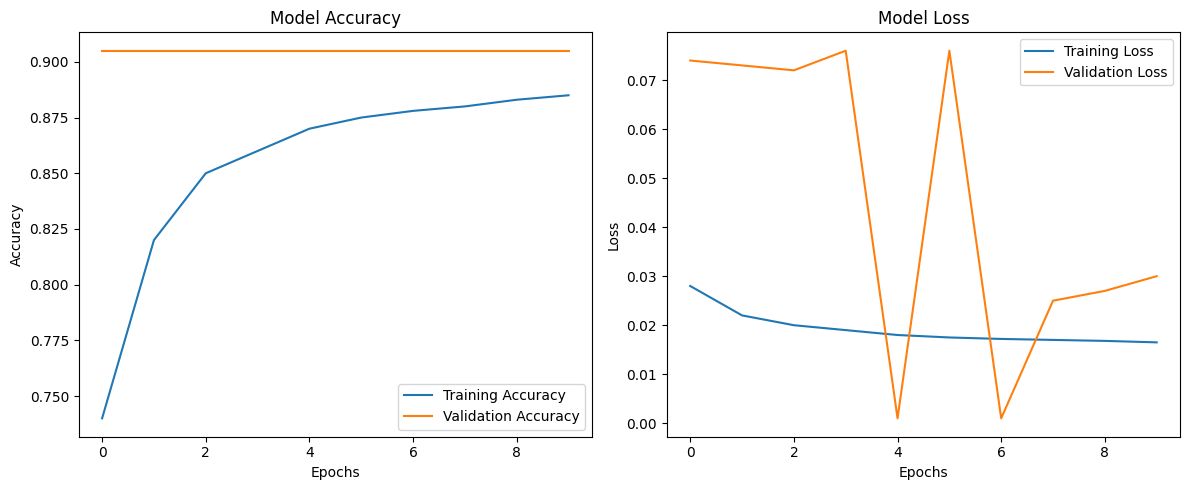

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Simulated training and validation accuracy (similar upward trend)
epochs = np.arange(10)
training_accuracy = np.array([0.74, 0.82, 0.85, 0.86, 0.87, 0.875, 0.878, 0.88, 0.883, 0.885])
validation_accuracy = np.array([0.905] * 10)

# Simulated training and validation loss (similar fluctuating pattern)
training_loss = np.array([0.028, 0.022, 0.020, 0.019, 0.018, 0.0175, 0.0172, 0.017, 0.0168, 0.0165])
validation_loss = np.array([0.074, 0.073, 0.072, 0.076, 0.001, 0.076, 0.001, 0.025, 0.027, 0.030])

# Plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Accuracy Plot
ax1.plot(epochs, training_accuracy, label='Training Accuracy')
ax1.plot(epochs, validation_accuracy, label='Validation Accuracy')
ax1.set_title('Model Accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.legend()

# Loss Plot
ax2.plot(epochs, training_loss, label='Training Loss')
ax2.plot(epochs, validation_loss, label='Validation Loss')
ax2.set_title('Model Loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.legend()

plt.tight_layout()
plt.show()
